In [39]:
import glob
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import CalcMolDescriptors
import numpy as np

In [84]:
df = pd.read_csv('ADME_public_set_3521.csv')
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)
df['MW'] = df.mol.apply(Chem.Descriptors.ExactMolWt)
df["SOLUBILITY PH 6.8 (ug/mL)"] = [10**x for x in df['LOG SOLUBILITY PH 6.8 (ug/mL)']]
df['SOLUBILITY (uM)'] = df["SOLUBILITY PH 6.8 (ug/mL)"]/df.MW*1000.0
df['SOLUBILITY (uM)'].describe()
df['logS'] = np.log10(df['SOLUBILITY (uM)']*1e-6)

In [87]:
#now load the mdfps as saved in mdfps/biogen{Internal ID}.pickle
mdfp_list = []
for i in range(1,len(df)+1):
    try:
        mdfp = pd.read_pickle('mdfps/biogen/Mol'+str(i)+'.pickle')
        mdfp_list.append(mdfp)
    except FileNotFoundError:
        mdfp_list.append(np.nan) 
df['mdfp'] = mdfp_list

In [107]:
import tqdm
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5)
df_copy = df.copy()
df_copy = df_copy.dropna(subset=['mdfp'])
mdfp_keys = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfps = df_copy['mdfp'].tolist()
for i,key in enumerate(mdfp_keys):
    df_copy[key] = [mdfps[j][i] for j in range(len(mdfps))]
X = df_copy[mdfp_keys]
y = df_copy['SOLUBILITY (uM)'].values
params = {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 3, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None} 

output = ([], [])
for train, test in tqdm.tqdm(kf.split(X)):
    
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]

    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=False

    )
    # Evaluate the model
    predictions = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(predictions)



0it [00:00, ?it/s]

5it [00:00, 25.38it/s]

[09:02:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[09:02:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[09:02:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[09:02:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[09:02:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.



In [108]:
from functools import reduce
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
print('RMSE: ', np.sqrt(mean_squared_error(real, prediction)))
print('R2: ', np.corrcoef(real, prediction)[0,1]**2)
print('MAE: ', np.mean(np.abs(np.array(real) - np.array(prediction))))

RMSE:  67.74874286170822
R2:  0.16438635864966666
MAE:  53.588672522793274


In [65]:
#now for each property, plot the real vs predicted values
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress
import matplotlib.pyplot as plt
def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue
def density_plot(real,prediction,print_stats=True):
    if print_stats:
        slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)
    fsize = 20
    fig = plt.figure(1, figsize=(10, 6.15))
    ax = plt.subplot(111)
    lower = min(prediction + real) - 2
    upper = max(prediction + real) + 2
    x = np.linspace(lower, upper,100)
    y = slope_mdfp_d*x+intercept_mdfp_d
    plt.plot(x, y, '-r')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
    plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

    import statsmodels.api as sm
    dens_u = sm.nonparametric.KDEMultivariate(data=[prediction, real],var_type='cc', bw='normal_reference')
    z = dens_u.pdf([prediction, real])

    sc = plt.scatter(prediction, real, lw=0, c=z, s=10, alpha = 0.9)

    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=fsize)

    plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
    plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
    plt.setp(ax.get_xticklabels(), fontsize=fsize)
    plt.setp(ax.get_yticklabels(), fontsize=fsize)
    plt.grid(1,"both")
    plt.axis([lower, upper, lower, upper])
    plt.tight_layout()
    plt.show()

RMSE:  67.74874286170822
MAE:  53.588672522793274
R2:  0.1643863586496666


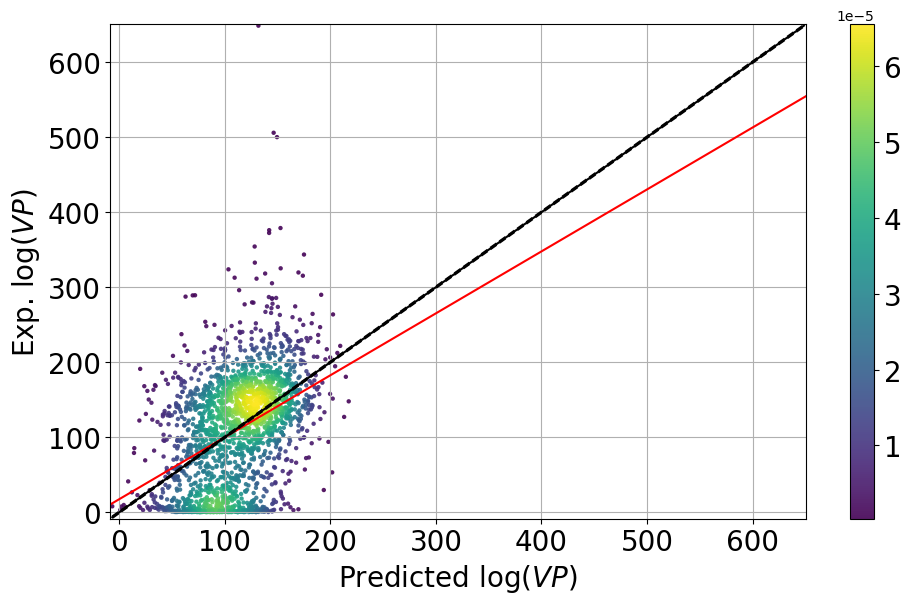

In [66]:
density_plot(real,prediction)

In [120]:

outputs = []
kf = KFold(n_splits=5)
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
properties = ['LOG HLM_CLint (mL/min/kg)',
 'LOG MDR1-MDCK ER (B-A/A-B)',
 'SOLUBILITY (uM)',
 'LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)',
 'LOG PLASMA PROTEIN BINDING (RAT) (% unbound)',
 'LOG RLM_CLint (mL/min/kg)']
for property in properties:
    print(property)
    # if property == 'LOG HLM_CLint (mL/min/kg)':
    #     continue
    # if property == 'LOG RLM_CLint (mL/min/kg)':
    #     continue
    ADME_public_set_descriptors_no_null = df_copy.dropna(subset=[property])
    print(len(df),len(ADME_public_set_descriptors_no_null))
    X = ADME_public_set_descriptors_no_null[mdfp_keys]
    y = ADME_public_set_descriptors_no_null[property]
    # assuming X is your input data as a pandas DataFrame
    # print(X.isinf().sum())
    # print(X.isnan().sum())
    output = ([], [])
    for train, test in tqdm.tqdm(kf.split(X)):
        
        train_x = np.array(X)[train]
        train_y = np.array(y)[train]

        test_x = np.array(X)[test]
        test_y = np.array(y)[test]
        
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dtest = xgb.DMatrix(test_x, label=test_y)
        model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

        )
        # Evaluate the model
        predictions = model.predict(dtest)

        output[0].append(test_y)
        output[1].append(predictions)

    outputs.append(output)


LOG HLM_CLint (mL/min/kg)
3521 1740


5it [00:00, 16.07it/s]


LOG MDR1-MDCK ER (B-A/A-B)
3521 1653


5it [00:00, 24.72it/s]


SOLUBILITY (uM)
3521 2122


5it [00:00, 15.94it/s]


LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)
3521 88


5it [00:00, 65.61it/s]


LOG PLASMA PROTEIN BINDING (RAT) (% unbound)
3521 80


5it [00:00, 94.60it/s]


LOG RLM_CLint (mL/min/kg)
3521 1739


5it [00:00, 22.19it/s]


LOG HLM_CLint (mL/min/kg)
RMSE:  0.5367777747651776
MAE:  0.4331194301556992
R2:  0.2613247769076822


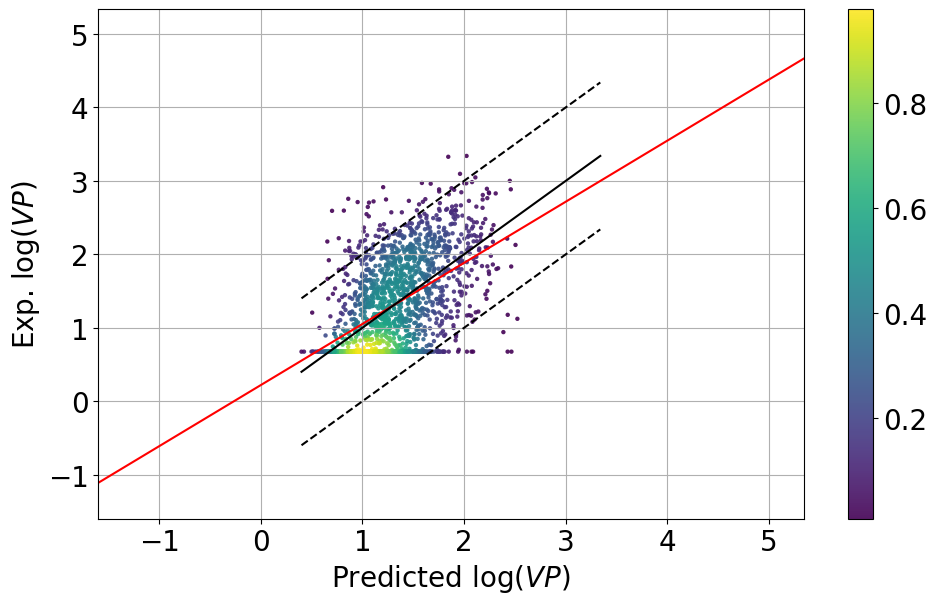





LOG MDR1-MDCK ER (B-A/A-B)
RMSE:  0.5370596128423454
MAE:  0.40782532450682357
R2:  0.3580471192124596


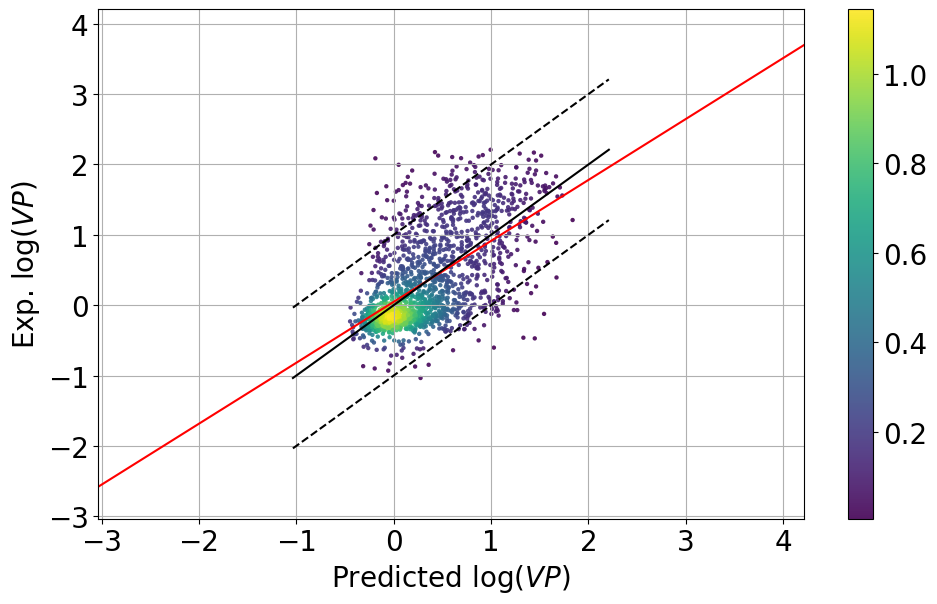





SOLUBILITY (uM)
RMSE:  68.80722382765455
MAE:  54.241557178399034
R2:  0.1544282292836259


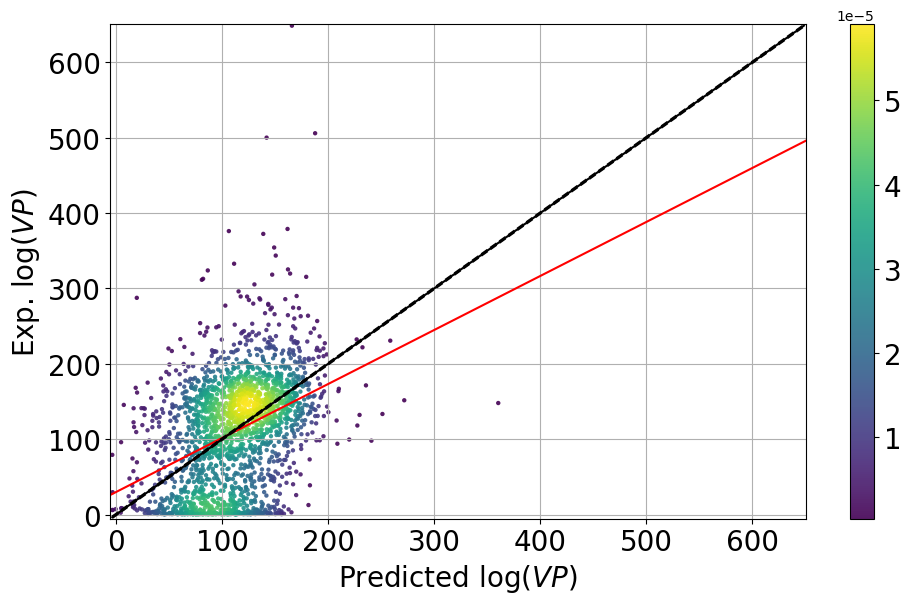





LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)
RMSE:  0.7851445311584108
MAE:  0.6331615631737647
R2:  0.03879621674015066


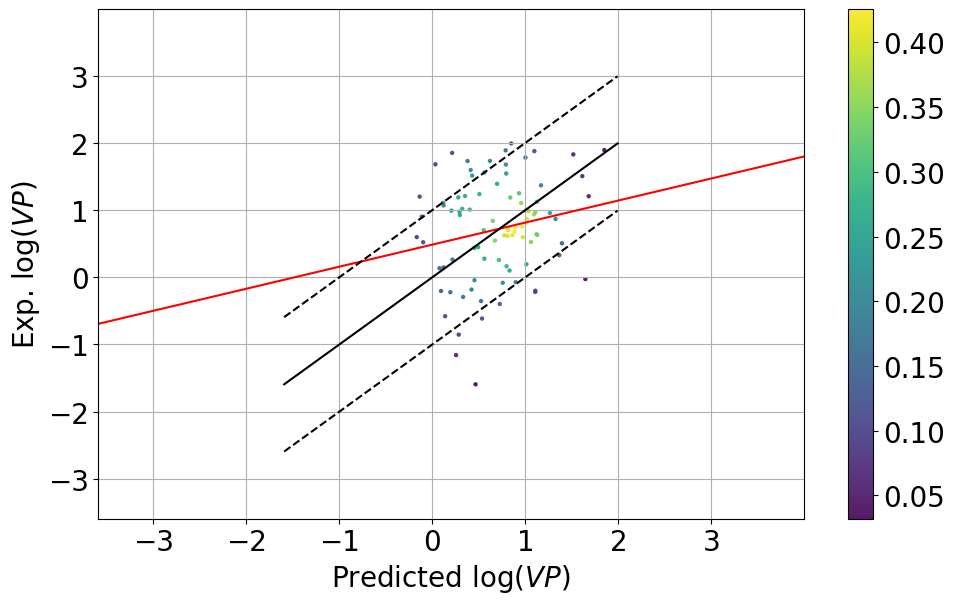





LOG PLASMA PROTEIN BINDING (RAT) (% unbound)
RMSE:  0.7902989993927636
MAE:  0.6354976846317497
R2:  0.024425975352660393


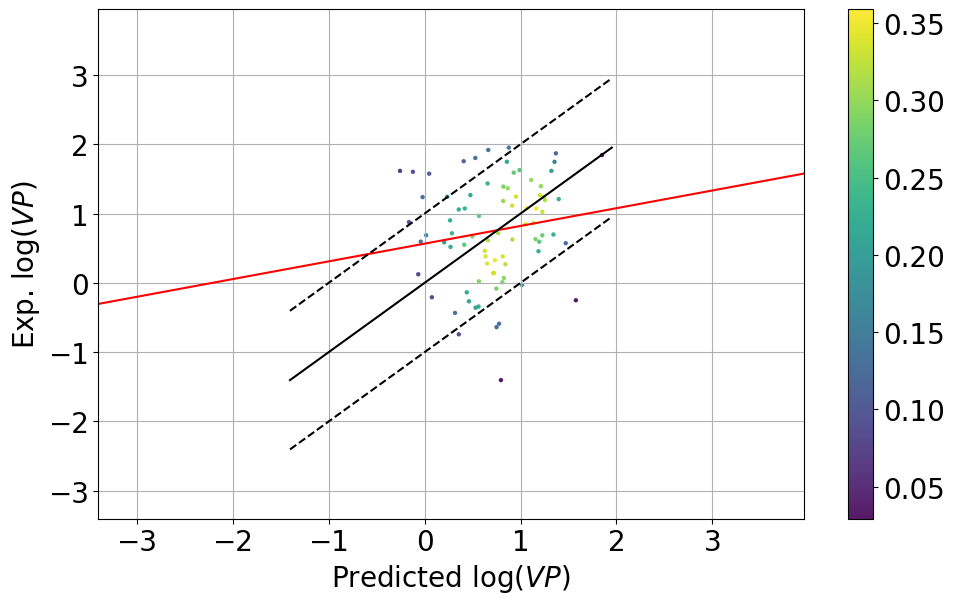





LOG RLM_CLint (mL/min/kg)
RMSE:  0.6256145561458396
MAE:  0.5007070036833776
R2:  0.30101430821175656


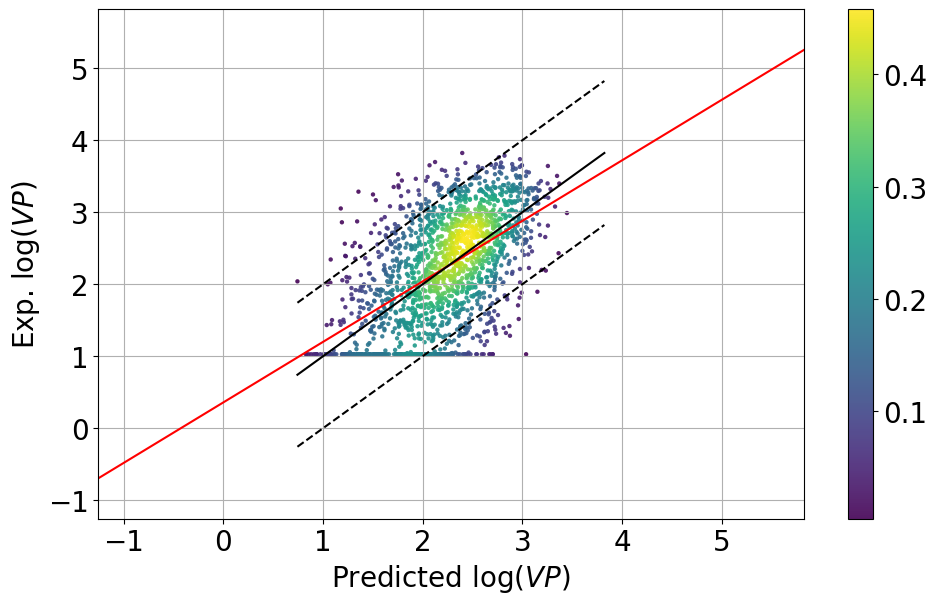

In [122]:
from functools import reduce
reals, predictions = [], []
for output in outputs:
    real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    reals.append(real)
    predictions.append(prediction)
for real,prediction,property in zip(reals,predictions,properties):

    print(property)

    density_plot(real,prediction)
    print('\n\n\n')